## Gsheets data loader

In [4]:
import re

def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for CSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

## Load Data

In [163]:
def get_outlier(data: pd.DataFrame, num_col: str) -> pd.Series:
    """
    Identify outliers in a specified numerical column based on the IQR method.

    This function calculates the interquartile range (IQR) for the specified column,
    defines the lower and upper bounds for outliers as 1.5 * IQR below Q1 and above Q3,
    and returns a boolean Series indicating whether each row in the column is an outlier.

    Args:
        data (pd.DataFrame): The input DataFrame containing the data.
        num_col (str): The name of the numerical column to check for outliers.

    Returns:
        pd.Series: A boolean Series where True indicates an outlier in the specified column.
    """
    q1 = data[num_col].quantile(0.25)
    q3 = data[num_col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Use np.where to identify outliers efficiently
    return np.where((data[num_col] < lower_bound) | (data[num_col] > upper_bound), True, False)

### Load ISDA Data

In [200]:
import pandas as pd

# Replace with your modified URL
isda_url = 'https://docs.google.com/spreadsheets/d/1MT5KXD_q0hOnCL_DATJU8DOcUFHZi-jPArFh5RMcPgw/edit?gid=1107019505#gid=1107019505'
isda_url = convert_google_sheet_url(isda_url)
isda_df = pd.read_csv(isda_url)


#### Select Columns

In [201]:
isda_df.columns

Index(['longitude', 'latitude', 'start_date', 'end_date', 'source',
       'horizon_lower', 'horizon_upper', 'aluminium_extractable',
       'boron_extractable', 'calcium_extractable', 'carbon_organic',
       'carbon_total', 'copper_extractable', 'electrical_conductivity',
       'iron_extractable', 'magnesium_extractable', 'manganese_extractable',
       'nitrogen_total', 'ph', 'phosphorus_extractable',
       'potassium_extractable', 'sodium_extractable', 'sulphur_extractable',
       'zinc_extractable'],
      dtype='object')

In [202]:
isda_df = isda_df[[
    'ph',
    'carbon_organic',
    'nitrogen_total',
    'potassium_extractable',
    'phosphorus_extractable',
    'sulphur_extractable',
    'boron_extractable',
    'zinc_extractable'
]]

In [203]:
num_cols = ['ph', 'soc', 'n', 'k', 'p', 's', 'b', 'zn']
isda_num_col_names = {
    'ph': 'pH Levels',
    'soc': 'Soil Organic Carbon g/kg',
    'n': 'Nitrogen g/kg',
    'k': 'Potassium mg/kg',
    'p': 'Phosphorus mg/kg',
    's': 'Sulfur mg/kg',
    'b': 'Boron mg/kg',
    'zn': 'Zinc mg/kg'
}
# Update column Names
isda_df.columns = updated_num_cols

In [204]:
isda_df.head()

,ph,soc,n,k,p,s,b,zn
0,5.942,30.66,2.24,283.103,NaN,NaN,NaN,NaN
1,5.722,21.15,1.57,215.459,NaN,NaN,NaN,NaN
2,5.510,15.64,1.02,398.656,NaN,NaN,NaN,NaN
3,5.817,15.63,1.12,267.354,NaN,NaN,NaN,NaN
4,4.980,18.49,1.19,229.682,NaN,NaN,NaN,NaN


#### Remove Outliers

In [205]:
from functools import reduce

outlier_maps = [get_outlier(isda_df, col) for col in updated_num_cols]
combined_outlier_map = reduce(lambda x, y: x | y, outlier_maps)

filtered_isda_df = isda_df[~combined_outlier_map]
filtered_isda_df.head()

,ph,soc,n,k,p,s,b,zn
1,5.722,21.15,1.57,215.459,NaN,NaN,NaN,NaN
2,5.510,15.64,1.02,398.656,NaN,NaN,NaN,NaN
3,5.817,15.63,1.12,267.354,NaN,NaN,NaN,NaN
4,4.980,18.49,1.19,229.682,NaN,NaN,NaN,NaN
5,5.269,13.48,0.91,97.396,NaN,NaN,NaN,NaN


#### Remove Nulls

In [206]:
filtered_isda_df = filtered_isda_df.dropna()
filtered_isda_df.isna().sum()

,0
ph,0
soc,0
n,0
k,0
p,0
s,0
b,0
zn,0


#### Update Units

IPAGE

- SOC %
- pH
- Nitrogen %
- Potassium meq/100
- Phosphorus ug/g
- Sulfur S ug/g
- Boron ug/g
- Zinc ug/g

Note:

1 cmol/kg = 1 meq/100

Multiply mol/kg by the atomic weight of potassium to convert to mg/kg.

cmol/kg * 1mol/100cmol * 39.1 g/mol -> 1 cmol/kg = 39.1/100 g/kg

mg/kg to meq/100

mg/kg * 1g/1000mg * (1 meq/100) / (39.1/100 g/kg)



References:
https://www.researchgate.net/post/How_to_convert_cmol_kg_to_mg_kg

In [207]:
filtered_isda_df.soc = filtered_isda_df.soc / 10 # g/kg to % (g/100g)
filtered_isda_df.n = filtered_isda_df.n / 10 # g/kg to % (g/100g)

# mg/kg to meq/100 (or cmol/kg)
filtered_isda_df.k = filtered_isda_df.k / (1000 * (39.1/100))

# mg/kg to ug/g (1:1)

In [208]:
isda_num_col_names['k'] = 'Potassium meq/100'
isda_num_col_names['soc'] = 'Soil Organic Carbon %'
isda_num_col_names['n'] = 'Nitrogen %'
isda_num_col_names['p'] = 'Phosphorus ug/g'
isda_num_col_names['s'] = 'Sulfur ug/g'
isda_num_col_names['b'] = 'Boron ug/g'
isda_num_col_names['zn'] = 'Zinc ug/g'

### Load IPAGE Data

In [209]:
ipage_url = 'https://docs.google.com/spreadsheets/d/1bwQyhW4bPA04sPy8JppZft_sM8O-j-DK06UDYR813Ik/edit?gid=0#gid=0'
ipage_url = convert_google_sheet_url(ipage_url)
ipage_df = pd.read_csv(ipage_url)

#### Update Column Names

In [210]:
cat_cols = ['area', 'year_data_added', 'soil_group', 'land_class', 'soil_type']
num_cols = ['ph', 'soc', 'n', 'k', 'p', 's', 'b', 'zn']
ipage_df.columns = cat_cols + num_cols
ipage_df.head()

,area,year_data_added,soil_group,land_class,soil_type,ph,soc,n,k,p,s,b,zn
0,Mithpukur,2005,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86
1,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,Mithpukur,2005,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,Mithpukur,2005,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.0
4,Mithpukur,2005,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04


#### Fix non-numeric rows

In [211]:
import re
import numpy as np

def clean_num_data(data):
    if pd.isna(data):
        return np.nan
    cleaned_data = re.sub(r'[^0-9.]+', '', str(data)) # remove non-numeric characters except dots
    cleaned_data = re.sub(r'\.{2,}', '.', cleaned_data) # fix series of dots (Ex. 0..01)
    cleaned_data = re.sub(r'^\.', '', cleaned_data) # remove dot at the beginning (Ex. .0.01)
    cleaned_data = re.sub(r'(\d*\.\d*)\.', r'\1', cleaned_data) # keep first dot remove the others (0.0.1)

    if not cleaned_data:
        return np.nan
    else:
        return float(cleaned_data)

ipage_df[num_cols] = ipage_df[num_cols].map(lambda x: clean_num_data(x))

#### Remove Outliers

In [212]:
from functools import reduce

outlier_maps = [get_outlier(ipage_df, col) for col in num_cols]
combined_outlier_map = reduce(lambda x, y: x | y, outlier_maps)

filtered_ipage_df = ipage_df[~combined_outlier_map]
filtered_ipage_df.head()

,area,year_data_added,soil_group,land_class,soil_type,ph,soc,n,k,p,s,b,zn
1,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,Mithpukur,2005,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,Mithpukur,2005,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00
4,Mithpukur,2005,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04
5,Mithpukur,2005,belab,high ground,Clay loam,4.9,1.87,0.08,0.35,21.7,27.8,0.32,1.16


#### Remove Nulls

In [213]:
filtered_ipage_df = filtered_ipage_df.dropna()
filtered_ipage_df.isna().sum()

,0
area,0
year_data_added,0
soil_group,0
land_class,0
soil_type,0
ph,0
soc,0
n,0
k,0
p,0


In [214]:
filtered_ipage_df = filtered_ipage_df[num_cols]

## EDA

In [217]:
def col_iterator():
    for col_name in num_cols:
        yield col_name

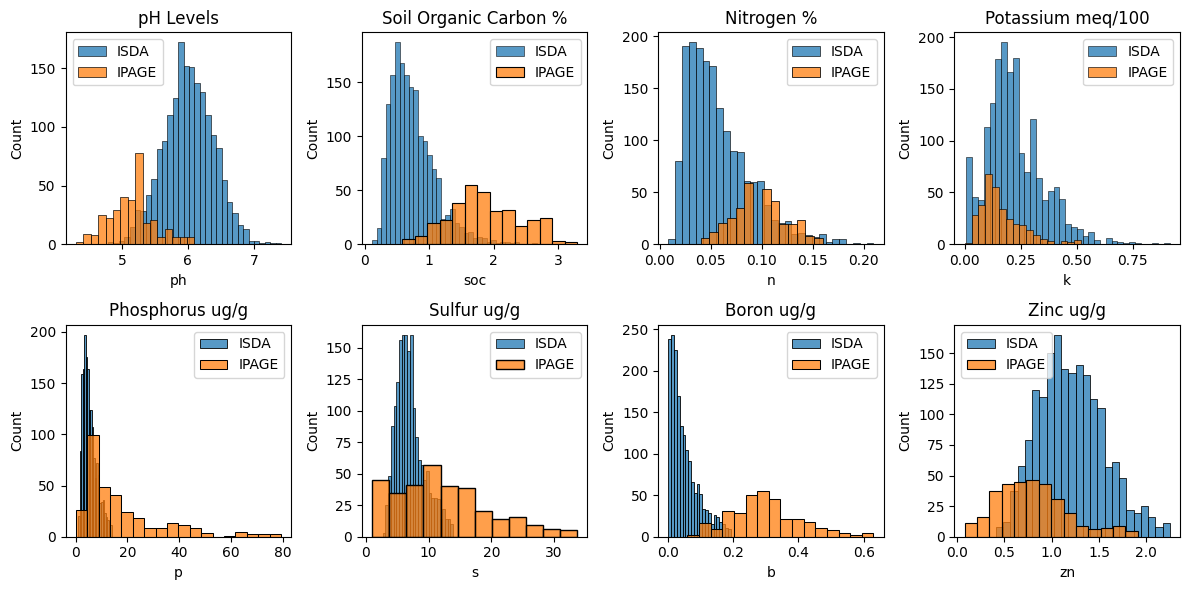

In [230]:
fig, arr = plt.subplots(2, 4, figsize=(12, 6))

col_iter = col_iterator()

for arr_row in arr:
    for arr_col in arr_row:
        col_name = next(col_iter)
        arr_col.set_title(isda_num_col_names[col_name])
        sns.histplot(data=filtered_isda_df, x=col_name, ax=arr_col, label = 'ISDA')
        sns.histplot(data=filtered_ipage_df, x=col_name, ax=arr_col, label = 'IPAGE')
        arr_col.legend()

fig.tight_layout()
